# Electron and hole polarons in oxides

## Background 
This repository contains raw input and ouput data, as well as all data analysis steps, for the publication *Nature of Electron and Hole Charge Carriers in Metal Oxides* - D. W. Davies et. al. 2019. 

This is the main notebook, which can be used to demonstrate the key results from the paper. It does not handle any of the raw data, so it can be run as-is, as long as you have all the requried packages installed. 

#### Requirements

`pip install numpy, scipy, pandas, smact` 

#### Important equations
Polaron energy is estimated using carrier effective mass and effective dielectric constant:    

$E_{polaron} = \frac{1}{4\pi^2} \frac{m^*e^4}{2\hbar^2\epsilon^2_{eff}}$

Effective dielectric constant is related to the optical and static dielectric constants by:    

$\frac{1}{\epsilon_{eff}} = \frac{1}{\epsilon_{\infty}} - \frac{1}{\epsilon_{0}}$

#### Restriction to oxides
We allow potentially anionic non-metals (e.g. P, As) but exclude compounds with complex anions such as NO3, PO3 etc. We also exclude some specific peroxides. This is done using an external filter function (see `filter_functions.py`) to keep the notebook tidy.

## Raw data
The raw data is imported from two sources (in **Supplementary Notebook 1**): 
1. [Effective masses](https://www.nature.com/articles/sdata201785)
2. [Dielectric constants](https://www.nature.com/articles/sdata201865)

The datasets are downloaded in their entirety from the repositories listed in the papers.
From (1) we extract the electron and hole effective mass tensor calcuated using GGA for $300K$ at carrier conc. of $1\times10^{18}$ (`n_eff_mass` and `p_eff_mass` respectively). From (2) we extract the total (static) and optical (electronic) dielectric tensor (`eps_total` and `eps_electronic`/`eps_inf` respectively). 

Data preprocessing steps:
 - Get the intersection of the datasets by checking that *any* of the unique Materials Project `task_id`s associated with each compound in set 1 is used to identify a compound in set 2.
 - Limit the entries to those that include at least one metal or semi-metal element (also including Si). 

The resulting data is imported below.

In [3]:
### Imports ###
import pandas as pd
import numpy as np
from scipy.stats import hmean   # harmonic mean
from smact import metals   # list of metal elements 
from scripts.filter_functions import proper_oxides   # filter for oxides 

# Matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Pandas options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

### Matplotlib style ###
mpl.rc_file('./matplotlibrc')
mpl.rcParams["text.latex.preamble"] = (r'\usepackage[version=3]{mhchem}')
mpl.rcParams['figure.figsize'] = (12.0,10.0)
mpl.style.use('ggplot')
clrs = ['#254654','#219e8f', '#eac563', '#f6a25a', '#e96f4c']

In [2]:
mpl.rcParams["text.usetex"]

True

## Effective mass histograms

In [4]:
# Open effmass data 
with open('../processed_data/raw_eff_mass_data.json', 'r') as f:
    effmass_data = pd.read_json(f)

effmass_data = effmass_data.reset_index(drop=True)

# Calculate average (polycrystalline) effective mass using harmonic mean
effmass_data['n_eff_mass_poly'] = effmass_data.apply(lambda x: hmean(x['n_eff_mass']), axis=1)
effmass_data['p_eff_mass_poly'] = effmass_data.apply(lambda x: hmean(x['p_eff_mass']), axis=1)

In [5]:
# Apply the oxides filter
effmass_oxides = proper_oxides(effmass_data, metal_oxides_only=True, 
                               specific_formulas=['K3NbO8','K2O2'])

Oxygen only: No other non-metals are being allowed!
==> After restricting to metal oxides only: 6852
==> After removing common O-containing anions: 5550
==> After removing additional specific formulas: 5548


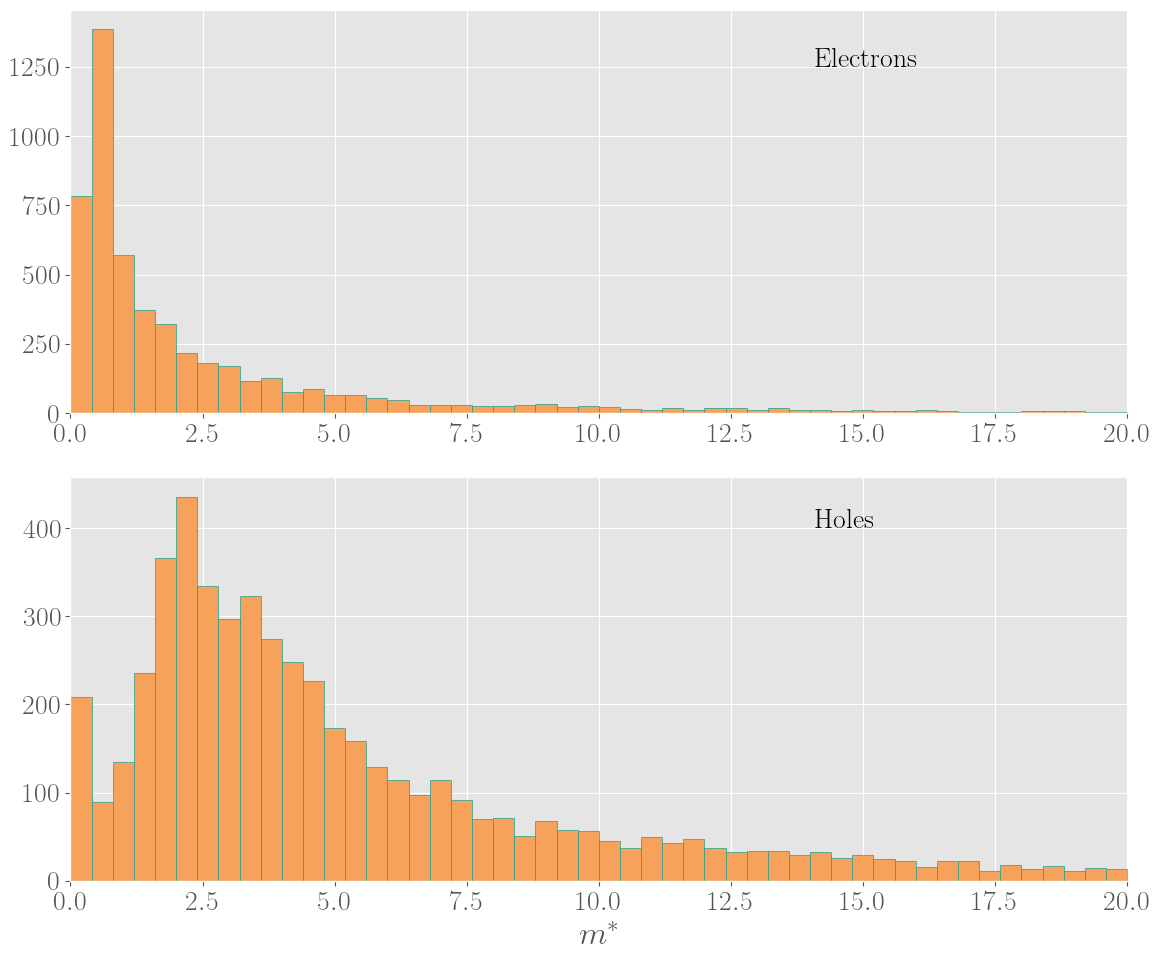

In [7]:
mpl.rcParams["font.size"] = "20"
electron_values = effmass_oxides['n_eff_mass_poly'].dropna()
electron_values = [i for i in electron_values if i < 20]

hole_values = effmass_oxides['p_eff_mass_poly'].dropna()
hole_values = [i for i in hole_values if i < 20]

binwidth = 0.4
bins = np.arange(0, max(hole_values) + binwidth, binwidth)

fig, axarr = plt.subplots(2)
elec_hist, bins, patches = axarr[0].hist(electron_values, bins=bins,edgecolor=clrs[1], color=clrs[3])
holes_hist, bins2, patches2 = axarr[1].hist(hole_values, bins=bins,edgecolor=clrs[1], color=clrs[3])
    
axarr[0].set_xlim(0,max(hole_values)+ .1)
axarr[1].set_xlim(0,max(hole_values) + .1)
#axarr[1].set_ylim(0,19)

axarr[0].text( 14.1,1250, 'Electrons', size=20)
axarr[1].text( 14.1,400, 'Holes', size=20)

#st = fig.suptitle('Oxides')
#st.set_y(1.0)

plt.xlabel('$m^*$')
plt.tight_layout()
plt.savefig('../Figures/f1-mass.png', dpi=300)
plt.show()

## E$_{polaron}$ histograms
We import the other processsed dataset, as we require information on effective mass and dielectric constant.

In [8]:
# Open collated data 
with open('../processed_data/collected_raw_data.json', 'r') as f:
    polaron_data = pd.read_json(f)

polaron_data = polaron_data.reset_index(drop=True)

print('Number of compounds: {}'.format(len(polaron_data)))

Number of compounds: 1131


### Calculate $E_{polaron}$

In [9]:
# Calculate average (polycrystalline) effective mass using harmonic mean
polaron_data['n_eff_mass_poly'] = polaron_data.apply(lambda x: hmean(x['n_eff_mass']), axis=1)
polaron_data['p_eff_mass_poly'] = polaron_data.apply(lambda x: hmean(x['p_eff_mass']), axis=1)

# Calculate average (polycrystalline) dielectric constants using arithmetic mean
def eps_poly(eps):
    eigenval = np.linalg.eig(eps)[0]
    return np.real(np.mean(eigenval))

polaron_data['eps_inf_poly'] = polaron_data.apply(lambda x: eps_poly(x['eps_electronic']), axis=1)
polaron_data['eps_total_poly'] = polaron_data.apply(lambda x: eps_poly(x['eps_total']), axis=1)

# Calculate epsilon_effective and E_polaron (in eV)
polaron_data['eps_eff_poly'] = 1./ ( (1./ polaron_data['eps_inf_poly']) - 
                                (1./ polaron_data['eps_total_poly']) )

# Finally, calculate E_polaron
def E_polaron(eff_mass, eps_eff):
    E =  (eff_mass/(4*(eps_eff**2))) * 13.605698066
    return(E)

polaron_data['E_polaron_hole'] = polaron_data.apply(lambda x: E_polaron(x['p_eff_mass_poly'],
                                                                       x['eps_eff_poly']), axis=1)
polaron_data['E_polaron_electron'] = polaron_data.apply(lambda x: E_polaron(x['n_eff_mass_poly'],
                                                                       x['eps_eff_poly']), axis=1)

In [10]:
# Apply the oxides filter
oxides = proper_oxides(polaron_data, metal_oxides_only=True, specific_formulas=['K3NbO8','K2O2'])

Oxygen only: No other non-metals are being allowed!
==> After restricting to metal oxides only: 225
==> After removing common O-containing anions: 216
==> After removing additional specific formulas: 214


In [11]:
# Select columns of interest
oxides = oxides[['task_id','formula','n_eff_mass_poly','p_eff_mass_poly',
                        'eps_inf_poly','eps_total_poly','eps_eff_poly','E_polaron_hole',
                        'E_polaron_electron']]
# Rename columns 
oxides = oxides.rename(columns={'n_eff_mass_poly':'n_eff_mass', 
                                                'p_eff_mass_poly': 'p_eff_mass', 
                              'eps_inf_poly': 'eps_inf', 'eps_total_poly': 'eps_total', 
                              'eps_eff_poly': 'eps_eff'})
# Save to json
oxides.to_json('../processed_data/database_data.json')

In [12]:
oxides.sort_values(by='p_eff_mass', ascending=False).head()

,task_id,formula,n_eff_mass,p_eff_mass,eps_inf,eps_total,eps_eff,E_polaron_hole,E_polaron_electron
693,mp-7849,AlAsO4,0.621414,15.970011,2.411918,4.227490,5.616060,1.722275,0.067016
853,mp-4035,RbReO4,3.688236,15.145064,2.676148,5.314606,5.390525,1.772841,0.431735
801,mp-23054,NaBiO3,0.400229,13.353911,4.515038,10.461912,7.942986,0.719949,0.021578
366,mp-4482,NaSbO3,0.410709,11.704953,3.384263,8.117928,5.803792,1.181971,0.041474
666,mp-223,GeO2,0.433937,9.258864,3.209876,6.424169,6.415342,0.765207,0.035863


In [13]:
# Import processed data from above
with open('../processed_data/database_data.json','r') as f:
    oxides = pd.read_json(f)
oxides = oxides.reset_index(drop=True)

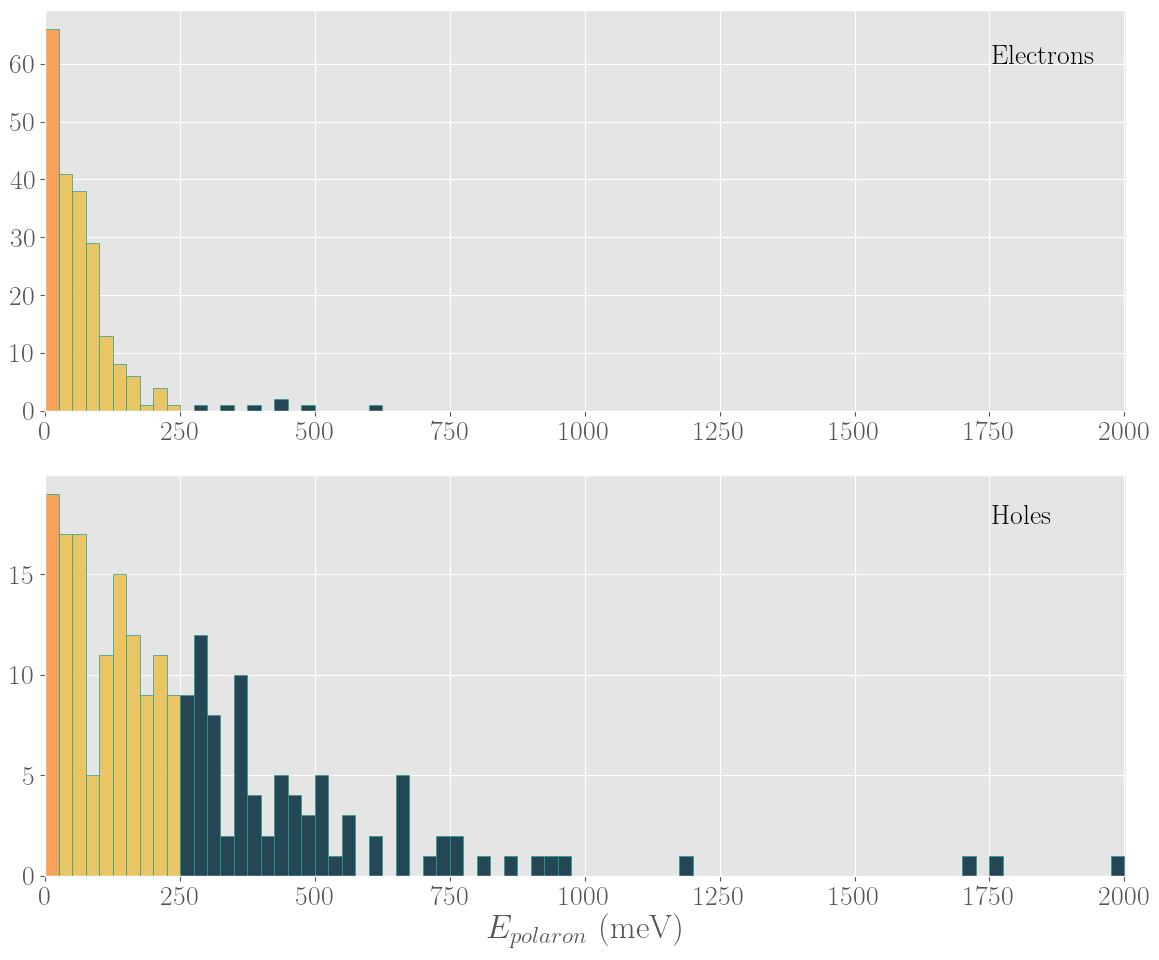

In [15]:
mpl.rcParams["font.size"] = "20"
electron_values = oxides['E_polaron_electron'].dropna()*1000
hole_values = oxides['E_polaron_hole'].dropna()*1000

binwidth = 25
bins = range(int(min(hole_values)), int(max(hole_values)) + binwidth, binwidth)


fig, axarr = plt.subplots(2)
elec_hist, bins, patches = axarr[0].hist(electron_values, bins=bins,edgecolor=clrs[1])
holes_hist, bins2, patches2 = axarr[1].hist(hole_values, bins=bins,edgecolor=clrs[1])

patches[0].set_facecolor(clrs[3])
patches2[0].set_facecolor(clrs[3])

for i in range(1,10):
    patches[i].set_facecolor(clrs[2])
    patches2[i].set_facecolor(clrs[2])
    
for i in range(10,80):
    patches[i].set_facecolor(clrs[0])
    patches2[i].set_facecolor(clrs[0])
    
axarr[0].set_xlim(0,max(hole_values)+ 20)
axarr[1].set_xlim(0,max(hole_values) + 20)

axarr[0].text( 1755,60, 'Electrons', size=20)
axarr[1].text( 1755,17.5, 'Holes', size=20)

plt.xlabel('$E_{polaron}$ (meV)')

plt.tight_layout()
plt.savefig('../Figures/f2-Epolaron.png', dpi=300)
plt.show()

In [16]:
# Find number of oxides with electron/hole m* < 1
light_electrons = oxides.loc[oxides['n_eff_mass'] < 1]
print(f'Number of oxides with electrons m* < 1: {len(light_electrons)}')

light_holes = oxides.loc[oxides['p_eff_mass'] < 1]
print(f'Number of oxides with holes m* < 1: {len(light_holes)}')

Number of oxides with electrons m* < 1: 168
Number of oxides with holes m* < 1: 23


### Hybrid-DFT calculations
We chose a subset of 10 compounds with the lowest $E_{polaron}^{hole}$ and performed more accurate hybrid-DFT (HSE06) calculations. We also included two materials with high polaron binding energies (12 materials total). 

In [28]:
# Low hole E_polaron
oxides.sort_values(by='E_polaron_hole').head(10)

,task_id,formula,n_eff_mass,p_eff_mass,eps_inf,eps_total,eps_eff,E_polaron_hole,E_polaron_electron
112,mp-1285,PtO2,1.551578,1.181001,18.780164,19.762834,377.694665,0.000028,0.000037
205,mp-14116,CuRhO2,0.581417,2.313784,12.130240,13.486376,120.631656,0.000541,0.000136
173,mp-27227,LiAg3O2,1.104366,0.783483,8.204319,10.946705,32.748957,0.002485,0.003503
177,mp-3744,NaNbO2,1.390303,0.754340,8.049970,10.849679,31.195959,0.002637,0.004859
55,mp-551873,Ca4Bi2O,0.326711,0.473600,12.262453,37.408921,18.242130,0.004841,0.003339
34,mp-546011,YZnAsO,0.469714,0.406280,9.739395,23.941429,16.418425,0.005127,0.005927
179,mp-27303,NaAg3O2,1.041448,1.196894,7.091533,9.741689,26.067718,0.005991,0.005213
97,mp-549589,LaZnAsO,0.248988,0.470377,9.703876,23.978522,16.300550,0.006021,0.003187
113,mp-12509,YZnPO,0.846452,0.576663,9.377826,19.688250,17.907409,0.006117,0.008978
166,mp-3924,LiNbO2,2.875364,0.758778,8.535232,14.883630,20.010596,0.006445,0.024425


In [18]:
# 2 compounds with high E_polaron energies
oxides.loc[oxides['formula'] == 'K2TiO3']

,task_id,formula,n_eff_mass,p_eff_mass,eps_inf,eps_total,eps_eff,E_polaron_hole,E_polaron_electron
175,mp-13133,K2TiO3,2.443938,2.573063,3.330182,17.894807,4.091623,0.522781,0.496546


In [19]:
oxides.loc[oxides['formula'] == 'NaSbO3']

,task_id,formula,n_eff_mass,p_eff_mass,eps_inf,eps_total,eps_eff,E_polaron_hole,E_polaron_electron
67,mp-4482,NaSbO3,0.410709,11.704953,3.384263,8.117928,5.803792,1.181971,0.041474


- The effective masses and electronic contribution to the dielectric constant `eps_inf_poly` are calculated using the hybrid-DFT approach, while the ionic contribution `eps_ion_poly` is calculated using DFPT with a GGA hybrid functional (PBEsol).
- All first-principles calculations are carried out using the VASP code and full details can be found in the main paper. 
- The same processing steps as above are carried out to calculate average (polycrystalline) effective massses, and polaron energies (see **Supplementary Notebook 2**).

The resulting data is imported below.

In [20]:
# Read in newly calculated data
hybrid_dft_data = pd.read_json('../processed_data/hybrid_calcs_data.json')

In [27]:
hybrid_dft_data = hybrid_dft_data.sort_values(by='E_polaron_hole', ascending=True)
hybrid_dft_data.head(12)

,formula,eps_ion,eps_inf,n_eff_mass,p_eff_mass,n_eff_mass_poly,p_eff_mass_poly,eps_total,eps_eff,E_polaron_hole,E_polaron_electron
9,PtO2,0.973290,7.086067,"[0.3999293739, 0.40448090540000003, 1.39253648...","[0.8129081007000001, 2.3181547377, 2.8912389542]",0.527161,1.494469,8.059357,58.676363,0.001476,0.000521
1,CuRhO2,1.365788,8.247800,"[0.4586616377, 0.4586632204, 0.6197820547]","[1.7274368836, 1.7274429196, 4.5621511007999995]",0.502178,2.178685,9.613588,58.055080,0.002199,0.000507
7,NaNbO2,2.724035,7.329100,"[0.9712358255, 1.4948749435, 1.494876133]","[0.5038388528000001, 0.5038392762, 1.138657301...",1.267149,0.618844,10.053135,27.048269,0.002877,0.005891
5,LiNbO2,6.339390,7.705967,"[2.4205156203, 2.4205241448, 7.2075209491]","[0.4237244529, 0.42372593750000004, 1.747812767]",3.108767,0.566874,14.045357,17.073102,0.006615,0.036276
4,LiAg3O2,2.822535,4.962000,"[0.889981232, 0.9439722185, 1.0772204513]","[0.3477721988, 0.7026923464, 1.9885432508]",0.964231,0.624815,7.784535,13.685166,0.011348,0.017512
0,Ca4Bi2O,36.551050,9.909700,"[0.4628720488, 0.46393469870000004, 1.1796648876]","[0.6013311204, 0.6035524761000001, 0.7244918218]",0.580990,0.638283,46.460750,12.596412,0.013683,0.012455
6,NaAg3O2,1.927031,4.383967,"[0.6372232742, 0.9563897839000001, 0.9804838352]","[0.6769420970000001, 0.8030784808, 5.1866496132]",0.825352,1.029074,6.310997,14.357427,0.016981,0.013619
11,YZnPO,10.790880,7.136900,"[0.4911341818, 0.4911349351, 0.7020637154]","[0.5296595264, 0.5296603328, 7.802664287]",0.545794,0.768409,17.927780,11.857121,0.018591,0.013205
3,LaZnAsO,18.191465,9.464400,"[0.39118662600000004, 0.39118662600000004, 0.8...","[0.9354648448, 0.9354648448, 2.0631968998]",0.481377,1.143877,27.655865,14.388405,0.018794,0.007909
10,YZnAsO,21.187880,8.693433,"[0.6512046402, 0.6512046402, 1.1208327088]","[1.1765934785, 1.1765934785, 1.7686200135]",0.756921,1.324366,29.881314,12.260368,0.029968,0.017128


### Carrier mobilities
For mobilities, we calculate the effective optic phonon frequency $\omega^{optic}$ (`omega`) that is responsible for electron-lattice interactions. This requires the Born effective charges, as well as phonon frequencies and energies, which are both produced during the DFPT calculation that has been carried out. The following workflow is then applied (see **Supplementary Notebook 2**): 

1. The `vasp-ir` script in Skelton's [phonopy-spectroscopy](https://github.com/JMSkelton/Phonopy-Spectroscopy) (Master branch 03/05/2018) package is used to produce a table of IR peak intensities.
2. These frequencies and intensities are averaged using the `HellwarthBscheme` in Frost's [PolaronMobility.jl](https://github.com/jarvist/PolaronMobility.jl) (v1.2.0) package. 
3. The `polaronmobility` function in the same package is used to calculate electron and hole mobility (`n_mobility` and `p_mobility` respectively), using a temperature of 300K. 
4. The resulting data is merged into the hybrid calculation dataframe and imported below.

In [29]:
hybrid_dft_data_mobilities = pd.read_json('../processed_data/hybrid_calcs_data_and_mobilities.json')
hybrid_dft_data_mobilities.head(12)

,formula,eps_ion,eps_inf,n_eff_mass,p_eff_mass,n_eff_mass_poly,p_eff_mass_poly,eps_total,eps_eff,E_polaron_hole,E_polaron_electron,omega,n_mobility,p_mobility
0,Ca4Bi2O,36.551050,9.909700,"[0.4628720488, 0.46393469870000004, 1.1796648876]","[0.6013311204, 0.6035524761000001, 0.7244918218]",0.580990,0.638283,46.460750,12.596412,0.013683,0.012455,105.368650,30.589132,26.200116
1,CuRhO2,1.365788,8.247800,"[0.4586616377, 0.4586632204, 0.6197820547]","[1.7274368836, 1.7274429196, 4.5621511007999995]",0.502178,2.178685,9.613588,58.055080,0.002199,0.000507,590.144263,631.025651,67.331576
2,K2TiO3,5.887970,2.992133,"[0.8779510699, 2.4248277346, 4.7826269079]","[0.9877743759000001, 3.1184794437, 58.2202823638]",1.704055,2.221857,8.880103,4.512668,0.371116,0.284628,370.013960,1.293661,0.697609
3,LaZnAsO,18.191465,9.464400,"[0.39118662600000004, 0.39118662600000004, 0.8...","[0.9354648448, 0.9354648448, 2.0631968998]",0.481377,1.143877,27.655865,14.388405,0.018794,0.007909,281.453383,67.437849,16.570584
4,LiAg3O2,2.822535,4.962000,"[0.889981232, 0.9439722185, 1.0772204513]","[0.3477721988, 0.7026923464, 1.9885432508]",0.964231,0.624815,7.784535,13.685166,0.011348,0.017512,428.787160,29.734437,59.856369
5,LiNbO2,6.339390,7.705967,"[2.4205156203, 2.4205241448, 7.2075209491]","[0.4237244529, 0.42372593750000004, 1.747812767]",3.108767,0.566874,14.045357,17.073102,0.006615,0.036276,419.763007,5.568217,88.428108
6,NaAg3O2,1.927031,4.383967,"[0.6372232742, 0.9563897839000001, 0.9804838352]","[0.6769420970000001, 0.8030784808, 5.1866496132]",0.825352,1.029074,6.310997,14.357427,0.016981,0.013619,439.473386,41.754521,29.233625
7,NaNbO2,2.724035,7.329100,"[0.9712358255, 1.4948749435, 1.494876133]","[0.5038388528000001, 0.5038392762, 1.138657301...",1.267149,0.618844,10.053135,27.048269,0.002877,0.005891,464.000723,47.453522,144.692869
8,NaSbO3,3.954798,2.784433,"[0.35183739950000004, 0.3518379222, 0.5596881907]","[8.6818442218, 8.6818573283, 13.9308825832]",0.401545,9.928890,6.739231,4.744854,1.500085,0.060666,452.817921,32.633851,0.062644
9,PtO2,0.973290,7.086067,"[0.3999293739, 0.40448090540000003, 1.39253648...","[0.8129081007000001, 2.3181547377, 2.8912389542]",0.527161,1.494469,8.059357,58.676363,0.001476,0.000521,712.924892,853.448328,175.066563


#### Summary table
We can produce a summary table like the one in the paper, which compares results obtained from tha databases with the results obtained using hybrid DFT.

In [31]:
# Merge the datasets
merged_data = hybrid_dft_data_mobilities.merge(oxides, how='inner', on='formula',
                                   suffixes=('_hybrid','_dataset'))
# Export a table with all columns 
merged_data.to_csv('../processed_data/full_comparison_table.csv')

# Select colums of interest
summary = merged_data[['formula','E_polaron_electron_dataset','E_polaron_electron_hybrid',
                      'E_polaron_hole_dataset','E_polaron_hole_hybrid','omega','n_mobility',
                       'p_mobility', 'n_eff_mass_poly', 'p_eff_mass_poly', 'n_eff_mass_dataset',
                      'p_eff_mass_dataset']]

# Sort by hole polaron energy (according to database values)
summary = summary.sort_values(by='E_polaron_hole_dataset')

# Export a table with reduced columns (as is in the paper)
summary.to_csv('../processed_data/summary_table.csv')

summary.head(12)

,formula,E_polaron_electron_dataset,E_polaron_electron_hybrid,E_polaron_hole_dataset,E_polaron_hole_hybrid,omega,n_mobility,p_mobility,n_eff_mass_poly,p_eff_mass_poly,n_eff_mass_dataset,p_eff_mass_dataset
9,PtO2,0.000037,0.000521,0.000028,0.001476,712.924892,853.448328,175.066563,0.527161,1.494469,1.551578,1.181001
1,CuRhO2,0.000136,0.000507,0.000541,0.002199,590.144263,631.025651,67.331576,0.502178,2.178685,0.581417,2.313784
4,LiAg3O2,0.003503,0.017512,0.002485,0.011348,428.787160,29.734437,59.856369,0.964231,0.624815,1.104366,0.783483
7,NaNbO2,0.004859,0.005891,0.002637,0.002877,464.000723,47.453522,144.692869,1.267149,0.618844,1.390303,0.754340
0,Ca4Bi2O,0.003339,0.012455,0.004841,0.013683,105.368650,30.589132,26.200116,0.580990,0.638283,0.326711,0.473600
10,YZnAsO,0.005927,0.017128,0.005127,0.029968,307.175588,28.234225,11.101244,0.756921,1.324366,0.469714,0.406280
6,NaAg3O2,0.005213,0.013619,0.005991,0.016981,439.473386,41.754521,29.233625,0.825352,1.029074,1.041448,1.196894
3,LaZnAsO,0.003187,0.007909,0.006021,0.018794,281.453383,67.437849,16.570584,0.481377,1.143877,0.248988,0.470377
11,YZnPO,0.008978,0.013205,0.006117,0.018591,301.705928,45.574322,26.039527,0.545794,0.768409,0.846452,0.576663
5,LiNbO2,0.024425,0.036276,0.006445,0.006615,419.763007,5.568217,88.428108,3.108767,0.566874,2.875364,0.758778
